<a href="https://colab.research.google.com/github/KiavashJamshidi/Hand-gender-prediction/blob/main/hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch import nn
from tqdm import tqdm
from glob import glob
from pandas import read_csv
from scipy.io import loadmat
from google.colab import drive
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torchvision.models import alexnet
from torch.nn.functional import softmax
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid, save_image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import ReLU, Linear, Conv2d, Softmax, CrossEntropyLoss

In [2]:
IMG_PATH = "/content/drive/MyDrive/Hands/"
LABEL_PATH = "/content/drive/MyDrive/HandInfo.csv"
OUT_PATH =  "/content/drive/MyDrive/Outs/"

In [3]:
mean1, mean2, mean3 = 240.45/255, 229.64/255, 223.24/255 #low
mean = 245.56/255 #high

In [4]:
std1, std2, std3 = 32.38/255, 48.41/255, 58.85/255 #low


In [5]:
device = torch.device("cuda:0")

In [6]:
def getPartOfMat(mat,status):
  if status == 'low':
    return mat['O'][:,:,:3]
  elif status == 'high':
    return mat['O'][:,:,3]
  elif status == "normal":
    return mat['O']

In [7]:
images = glob(IMG_PATH + '*.jpg')

In [8]:
images.sort()

In [9]:
print(len(images))

11076


In [10]:
details = read_csv(LABEL_PATH)

In [11]:
print(details)

         id  age  gender  ...  aspectOfHand         imageName  irregularities
0         0   27    male  ...  dorsal right  Hand_0000002.jpg               0
1         0   27    male  ...  dorsal right  Hand_0000003.jpg               0
2         0   27    male  ...  dorsal right  Hand_0000004.jpg               0
3         0   27    male  ...  dorsal right  Hand_0000005.jpg               0
4         0   27    male  ...  dorsal right  Hand_0000006.jpg               0
...     ...  ...     ...  ...           ...               ...             ...
11071  1589   22  female  ...   palmar left  Hand_0011740.jpg               0
11072  1589   22  female  ...   palmar left  Hand_0011741.jpg               0
11073  1589   22  female  ...   palmar left  Hand_0011742.jpg               0
11074  1589   22  female  ...   palmar left  Hand_0011743.jpg               0
11075  1589   22  female  ...   palmar left  Hand_0011744.jpg               0

[11076 rows x 9 columns]


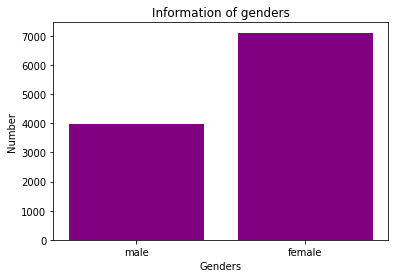

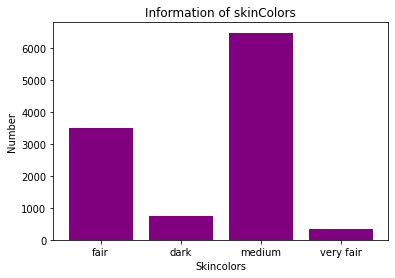

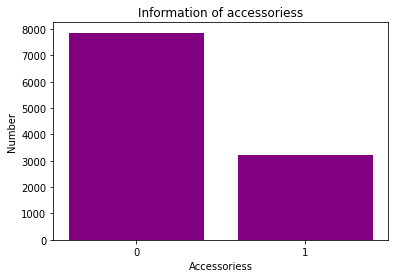

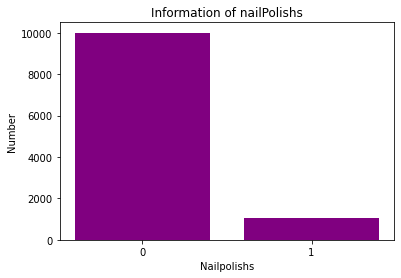

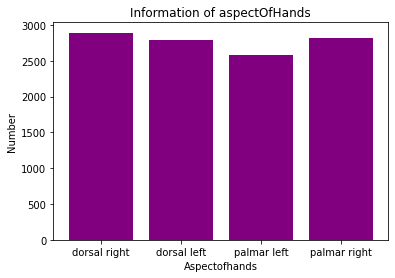

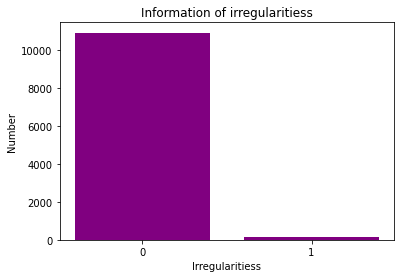

In [12]:
for col in details.columns:
  if col == "id" or col == "imageName" or col == "age": continue
  types = {}
  for row in details[col]:
    if row in types:
      types[row] += 1
      continue
    else:
      types[row] = 0
  plt.bar(range(len(types)), list(types.values()), tick_label=list(types.keys()), color = 'purple')
  plt.title("Information of " + col + "s")
  plt.xlabel(col.capitalize() + "s")
  plt.ylabel('Number')
  plt.show()

In [13]:
outs = glob(OUT_PATH + '*.mat')

In [14]:
outs.sort()

In [15]:
def checkImgOut(images,outs):
  errorFound = len(images) != len(outs)
  for i in range(len(images)):
    a = images[i].split('/')[-1].split('.')[0].split('_')[1]
    b = outs[i].split('/')[-1].split('.')[0].split('_')[1]
    if a != b:
      errorFound = True
  return errorFound

In [16]:
if checkImgOut(images,outs):
  print("There is an error! fix it.")
  input()
else:
  print("Congrats! There is no error.")

Congrats! There is no error.


In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = read_csv(csv_path)
        self.imagesFolder = images_folder
        self.transform = transform
        self.class2index = {"male":0, "female":1}

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        filename = self.df["imageName"][index]
        label = self.class2index[self.df["gender"][index]]
        image = getPartOfMat(loadmat(self.imagesFolder + "/" + filename[:-3] + "mat"), "low")
        if self.transform is not None:
          image = self.transform(image)
        return image, label
      
    def images(self):
      return glob(self.imagesFolder + "/*.mat")
        

In [18]:
def getMean(outs):
  sum1, sum2, sum3 = 0, 0, 0
  for out in tqdm(outs):
    mat = loadmat(out)
    image = mat['O'][:,:,:3]
    sum1 += image[:,:,0].mean()
    sum2 += image[:,:,1].mean()
    sum3 += image[:,:,2].mean()
  mean1 = sum1 / len(outs)
  mean2 = sum2 / len(outs)
  mean3 = sum3 / len(outs)
  print(mean1, mean2, mean3)
  return mean1, mean2, mean3

In [19]:
# mean1, mean2, mean3 = getMean(outs)

In [20]:
loadmat(outs[0])['O'][:,:,0].shape

(224, 224)

In [21]:
def getStd(outs):
  sum1, sum2, sum3 = 0, 0, 0
  for out in tqdm(outs):
    mat = loadmat(out)
    image = mat['O'][:,:,:3]
    sum1 += np.power(image[:,:,0] - mean1, 2).sum()
    sum2 += np.power(image[:,:,1] - mean2, 2).sum()
    sum3 += np.power(image[:,:,2] - mean3, 2).sum()
  std1 = np.sqrt(sum1 / len(outs) / 224 / 224)
  std2 = np.sqrt(sum2 / len(outs) / 224 / 224)
  std3 = np.sqrt(sum3 / len(outs) / 224 / 224)
  print(std1, std2, std3)
  return std1, std2, std3

In [22]:
# std1, std2, std3 = getStd(outs)

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (std1, std2, std3))
])

In [24]:
dataset = CustomDataset(LABEL_PATH, OUT_PATH, transform)
img, label = dataset[100]
img.shape

torch.Size([3, 224, 224])

In [25]:
batch_size = 300
validation_split = 0.7
shuffle_dataset = True
dataset_size = len(dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
testLoader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [26]:
len(trainLoader)

26

In [27]:
len(testLoader)

12

In [28]:
alexNet = alexnet(pretrained=True)
alexNet = alexNet.to(device)
alexNet.classifier[6].out_features = 2
alexNet.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
state_dict = alexNet.state_dict()
weights = state_dict["features.0.weight"]
bias = state_dict["features.0.bias"]

In [ ]:
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

In [ ]:
optimizer = optim.SGD(alexNet.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times
  running_loss = 0.0
  total, correct = 0, 0
  # for data in trainLoader:
  for data in tqdm(trainLoader):

    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = alexNet(inputs)
    loss = criterion(outputs, labels)
    loss.backward(retain_graph=True)

    optimizer.step()

    # print(loss.item())
    running_loss += loss.item() / len(trainLoader)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()


  accuracy = 100 * correct / total
  trainAccuracy.append(accuracy)
  trainLoss.append(running_loss)
  print("\nTRAIN: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,10, accuracy, running_loss))


  4%|▍         | 1/26 [00:01<00:46,  1.86s/it]

10.217782020568848


  8%|▊         | 2/26 [00:03<00:43,  1.79s/it]

4.487980842590332


 12%|█▏        | 3/26 [00:05<00:40,  1.74s/it]

2.896885395050049


 15%|█▌        | 4/26 [00:07<00:38,  1.74s/it]

2.3231918811798096


 19%|█▉        | 5/26 [00:08<00:35,  1.71s/it]

0.6809860467910767


 23%|██▎       | 6/26 [00:10<00:33,  1.69s/it]

2.749999761581421


 27%|██▋       | 7/26 [00:11<00:31,  1.68s/it]

1.0470023155212402


 31%|███       | 8/26 [00:13<00:30,  1.67s/it]

1.0338789224624634


 35%|███▍      | 9/26 [00:15<00:27,  1.64s/it]

1.4372210502624512


 38%|███▊      | 10/26 [00:16<00:26,  1.64s/it]

1.5404542684555054


 42%|████▏     | 11/26 [00:18<00:24,  1.63s/it]

1.217150330543518


 46%|████▌     | 12/26 [00:20<00:23,  1.64s/it]

0.9694744944572449


 50%|█████     | 13/26 [00:21<00:21,  1.64s/it]

0.7781004905700684


 54%|█████▍    | 14/26 [00:23<00:19,  1.65s/it]

0.5972074270248413


 58%|█████▊    | 15/26 [00:25<00:18,  1.66s/it]

0.6751313805580139


 62%|██████▏   | 16/26 [00:26<00:16,  1.68s/it]

0.646822988986969


 65%|██████▌   | 17/26 [00:28<00:14,  1.67s/it]

0.5132747292518616


 69%|██████▉   | 18/26 [00:30<00:13,  1.67s/it]

0.5608541965484619


 73%|███████▎  | 19/26 [00:31<00:11,  1.67s/it]

0.6673777103424072


 77%|███████▋  | 20/26 [00:33<00:10,  1.68s/it]

0.5027914643287659


 81%|████████  | 21/26 [00:35<00:08,  1.68s/it]

0.6037729978561401


 85%|████████▍ | 22/26 [00:36<00:06,  1.69s/it]

0.5317419171333313


 88%|████████▊ | 23/26 [00:38<00:05,  1.68s/it]

0.5335647463798523


 92%|█████████▏| 24/26 [00:40<00:03,  1.68s/it]

0.48617762327194214


 96%|█████████▌| 25/26 [00:41<00:01,  1.66s/it]

0.4460465610027313


100%|██████████| 26/26 [00:43<00:00,  1.67s/it]


0.4654882848262787

TRAIN: Epoch 1/10, Accuracy: 64.323, Loss: 1.485


  4%|▍         | 1/26 [00:01<00:41,  1.66s/it]

0.5070375800132751


  8%|▊         | 2/26 [00:03<00:40,  1.67s/it]

0.4313187301158905


 12%|█▏        | 3/26 [00:04<00:38,  1.66s/it]

0.40644845366477966


 15%|█▌        | 4/26 [00:06<00:36,  1.67s/it]

0.3985053300857544


 19%|█▉        | 5/26 [00:08<00:34,  1.66s/it]

0.38478603959083557


 23%|██▎       | 6/26 [00:09<00:33,  1.66s/it]

0.4116235077381134


 27%|██▋       | 7/26 [00:11<00:31,  1.66s/it]

0.40302371978759766


 31%|███       | 8/26 [00:13<00:30,  1.67s/it]

0.3711572289466858


 35%|███▍      | 9/26 [00:14<00:28,  1.66s/it]

0.3636801838874817


 38%|███▊      | 10/26 [00:16<00:26,  1.67s/it]

0.3015652894973755


 42%|████▏     | 11/26 [00:18<00:24,  1.66s/it]

0.31994882225990295


 46%|████▌     | 12/26 [00:19<00:23,  1.67s/it]

0.3217356503009796


 50%|█████     | 13/26 [00:21<00:21,  1.67s/it]

0.2873665988445282


 54%|█████▍    | 14/26 [00:23<00:20,  1.69s/it]

0.33327680826187134


 58%|█████▊    | 15/26 [00:24<00:18,  1.67s/it]

0.28731390833854675


 62%|██████▏   | 16/26 [00:26<00:16,  1.67s/it]

0.3444133698940277


 65%|██████▌   | 17/26 [00:28<00:14,  1.66s/it]

0.3247678279876709


 69%|██████▉   | 18/26 [00:30<00:13,  1.67s/it]

0.28197726607322693


 73%|███████▎  | 19/26 [00:31<00:11,  1.66s/it]

0.28109946846961975


 77%|███████▋  | 20/26 [00:33<00:10,  1.68s/it]

0.29763707518577576


 81%|████████  | 21/26 [00:35<00:08,  1.67s/it]

0.2738630771636963


 85%|████████▍ | 22/26 [00:36<00:06,  1.67s/it]

0.27956581115722656


 88%|████████▊ | 23/26 [00:38<00:04,  1.66s/it]

0.2886107265949249


 92%|█████████▏| 24/26 [00:39<00:03,  1.66s/it]

0.28106212615966797


 96%|█████████▌| 25/26 [00:41<00:01,  1.65s/it]

0.2551610469818115


100%|██████████| 26/26 [00:43<00:00,  1.66s/it]


0.22227685153484344

TRAIN: Epoch 2/10, Accuracy: 85.477, Loss: 0.333


  4%|▍         | 1/26 [00:01<00:40,  1.61s/it]

0.2843487858772278


  8%|▊         | 2/26 [00:03<00:38,  1.62s/it]

0.21795640885829926


 12%|█▏        | 3/26 [00:04<00:36,  1.61s/it]

0.2327326238155365


 15%|█▌        | 4/26 [00:06<00:35,  1.63s/it]

0.21592208743095398


 19%|█▉        | 5/26 [00:08<00:34,  1.62s/it]

0.228516086935997


 23%|██▎       | 6/26 [00:09<00:32,  1.63s/it]

0.24595904350280762


 27%|██▋       | 7/26 [00:11<00:30,  1.63s/it]

0.23788031935691833


 31%|███       | 8/26 [00:13<00:29,  1.64s/it]

0.2258603870868683


 35%|███▍      | 9/26 [00:14<00:27,  1.63s/it]

0.21383638679981232


 38%|███▊      | 10/26 [00:16<00:26,  1.64s/it]

0.2199975550174713


 42%|████▏     | 11/26 [00:17<00:24,  1.63s/it]

0.23512455821037292


 46%|████▌     | 12/26 [00:19<00:22,  1.64s/it]

0.22082342207431793


 50%|█████     | 13/26 [00:21<00:21,  1.63s/it]

0.22115717828273773


 54%|█████▍    | 14/26 [00:22<00:19,  1.63s/it]

0.18903616070747375


 58%|█████▊    | 15/26 [00:24<00:17,  1.62s/it]

0.18868009746074677


 62%|██████▏   | 16/26 [00:26<00:16,  1.62s/it]

0.22452567517757416


 65%|██████▌   | 17/26 [00:27<00:14,  1.62s/it]

0.19458600878715515


 69%|██████▉   | 18/26 [00:29<00:12,  1.62s/it]

0.23061755299568176


 73%|███████▎  | 19/26 [00:30<00:11,  1.62s/it]

0.1902584582567215


 77%|███████▋  | 20/26 [00:32<00:09,  1.63s/it]

0.2346247136592865


 81%|████████  | 21/26 [00:34<00:08,  1.62s/it]

0.20425504446029663


 85%|████████▍ | 22/26 [00:35<00:06,  1.63s/it]

0.18838626146316528


 88%|████████▊ | 23/26 [00:37<00:04,  1.62s/it]

0.20748727023601532


 92%|█████████▏| 24/26 [00:39<00:03,  1.63s/it]

0.18799841403961182


 96%|█████████▌| 25/26 [00:40<00:01,  1.63s/it]

0.16493463516235352


100%|██████████| 26/26 [00:42<00:00,  1.62s/it]


0.20465870201587677

TRAIN: Epoch 3/10, Accuracy: 91.577, Loss: 0.216


  4%|▍         | 1/26 [00:01<00:40,  1.63s/it]

0.15810295939445496


  8%|▊         | 2/26 [00:03<00:39,  1.64s/it]

0.24117206037044525


 12%|█▏        | 3/26 [00:04<00:37,  1.63s/it]

0.16191110014915466


 15%|█▌        | 4/26 [00:06<00:36,  1.64s/it]

0.25473904609680176


 19%|█▉        | 5/26 [00:08<00:34,  1.63s/it]

0.1760401725769043


 23%|██▎       | 6/26 [00:09<00:32,  1.64s/it]

0.18546715378761292


 27%|██▋       | 7/26 [00:11<00:31,  1.63s/it]

0.17345598340034485


 31%|███       | 8/26 [00:13<00:29,  1.64s/it]

0.22684180736541748


 35%|███▍      | 9/26 [00:14<00:27,  1.63s/it]

0.22895802557468414


 38%|███▊      | 10/26 [00:16<00:26,  1.64s/it]

0.20021282136440277


 42%|████▏     | 11/26 [00:17<00:24,  1.64s/it]

0.2590372562408447


 46%|████▌     | 12/26 [00:19<00:23,  1.65s/it]

0.2084309607744217


 50%|█████     | 13/26 [00:21<00:21,  1.65s/it]

0.14917051792144775


 54%|█████▍    | 14/26 [00:22<00:19,  1.66s/it]

0.1788097321987152


 58%|█████▊    | 15/26 [00:24<00:18,  1.65s/it]

0.1338805854320526


 62%|██████▏   | 16/26 [00:26<00:16,  1.66s/it]

0.16297009587287903


 65%|██████▌   | 17/26 [00:27<00:14,  1.64s/it]

0.25470253825187683


 69%|██████▉   | 18/26 [00:29<00:13,  1.65s/it]

0.16826049983501434


 73%|███████▎  | 19/26 [00:31<00:11,  1.65s/it]

0.17941021919250488


 77%|███████▋  | 20/26 [00:32<00:09,  1.66s/it]

0.11955955624580383


 81%|████████  | 21/26 [00:34<00:08,  1.65s/it]

0.13691331446170807


 85%|████████▍ | 22/26 [00:36<00:06,  1.66s/it]

0.15108059346675873


 88%|████████▊ | 23/26 [00:37<00:04,  1.65s/it]

0.14836415648460388


 92%|█████████▏| 24/26 [00:39<00:03,  1.66s/it]

0.11640048772096634


 96%|█████████▌| 25/26 [00:41<00:01,  1.65s/it]

0.16415056586265564


100%|██████████| 26/26 [00:42<00:00,  1.64s/it]


0.151005819439888

TRAIN: Epoch 4/10, Accuracy: 93.112, Loss: 0.180


  4%|▍         | 1/26 [00:01<00:40,  1.63s/it]

0.10338377952575684


  8%|▊         | 2/26 [00:03<00:39,  1.63s/it]

0.20776119828224182


 12%|█▏        | 3/26 [00:04<00:37,  1.63s/it]

0.12096536159515381


 15%|█▌        | 4/26 [00:06<00:36,  1.64s/it]

0.11793579161167145


 19%|█▉        | 5/26 [00:08<00:34,  1.63s/it]

0.16196057200431824


 23%|██▎       | 6/26 [00:09<00:33,  1.65s/it]

0.16756032407283783


 27%|██▋       | 7/26 [00:11<00:31,  1.65s/it]

0.18918487429618835


 31%|███       | 8/26 [00:13<00:29,  1.65s/it]

0.17818421125411987


 35%|███▍      | 9/26 [00:14<00:27,  1.63s/it]

0.17678454518318176


 38%|███▊      | 10/26 [00:16<00:26,  1.64s/it]

0.2293296605348587


 42%|████▏     | 11/26 [00:18<00:24,  1.63s/it]

0.16586805880069733


 46%|████▌     | 12/26 [00:19<00:22,  1.63s/it]

0.11878085881471634


 50%|█████     | 13/26 [00:21<00:21,  1.63s/it]

0.15147577226161957


 54%|█████▍    | 14/26 [00:22<00:19,  1.64s/it]

0.10524929314851761


 58%|█████▊    | 15/26 [00:24<00:18,  1.65s/it]

0.20031772553920746


 62%|██████▏   | 16/26 [00:26<00:16,  1.66s/it]

0.0960489809513092


 65%|██████▌   | 17/26 [00:27<00:14,  1.66s/it]

0.16133257746696472


 69%|██████▉   | 18/26 [00:29<00:13,  1.67s/it]

0.16568344831466675


 73%|███████▎  | 19/26 [00:31<00:11,  1.65s/it]

0.12269489467144012


 77%|███████▋  | 20/26 [00:32<00:09,  1.65s/it]

0.18299944698810577


 81%|████████  | 21/26 [00:34<00:08,  1.64s/it]

0.10862360894680023


 85%|████████▍ | 22/26 [00:36<00:06,  1.64s/it]

0.16234228014945984


 88%|████████▊ | 23/26 [00:37<00:04,  1.63s/it]

0.09997943788766861


 92%|█████████▏| 24/26 [00:39<00:03,  1.63s/it]

0.13681788742542267


 96%|█████████▌| 25/26 [00:40<00:01,  1.62s/it]

0.21331611275672913


100%|██████████| 26/26 [00:42<00:00,  1.63s/it]


0.16492491960525513

TRAIN: Epoch 5/10, Accuracy: 94.093, Loss: 0.154


  4%|▍         | 1/26 [00:01<00:40,  1.61s/it]

0.15069590508937836


  8%|▊         | 2/26 [00:03<00:38,  1.62s/it]

0.11438992619514465


 12%|█▏        | 3/26 [00:04<00:37,  1.61s/it]

0.16863150894641876


 15%|█▌        | 4/26 [00:06<00:36,  1.64s/it]

0.1378353089094162


 19%|█▉        | 5/26 [00:08<00:33,  1.61s/it]

0.20384393632411957


 23%|██▎       | 6/26 [00:09<00:32,  1.62s/it]

0.09322844445705414


 27%|██▋       | 7/26 [00:11<00:30,  1.61s/it]

0.16386912763118744


 31%|███       | 8/26 [00:12<00:29,  1.62s/it]

0.11105760186910629


 35%|███▍      | 9/26 [00:14<00:27,  1.62s/it]

0.1220509484410286


 38%|███▊      | 10/26 [00:16<00:26,  1.63s/it]

0.14634709060192108


 42%|████▏     | 11/26 [00:17<00:24,  1.61s/it]

0.1006387323141098


 46%|████▌     | 12/26 [00:19<00:22,  1.62s/it]

0.12412387877702713


 50%|█████     | 13/26 [00:21<00:20,  1.61s/it]

0.14833633601665497


 54%|█████▍    | 14/26 [00:22<00:19,  1.62s/it]

0.1247040182352066


 58%|█████▊    | 15/26 [00:24<00:17,  1.61s/it]

0.20027782022953033


 62%|██████▏   | 16/26 [00:25<00:16,  1.61s/it]

0.10737325996160507


 65%|██████▌   | 17/26 [00:27<00:14,  1.60s/it]

0.10716622322797775


 69%|██████▉   | 18/26 [00:29<00:12,  1.61s/it]

0.14630679786205292


 73%|███████▎  | 19/26 [00:30<00:11,  1.61s/it]

0.11358240991830826


 77%|███████▋  | 20/26 [00:32<00:09,  1.62s/it]

0.1228838637471199


 81%|████████  | 21/26 [00:33<00:08,  1.62s/it]

0.0848061591386795


 85%|████████▍ | 22/26 [00:35<00:06,  1.63s/it]

0.11272536963224411


 88%|████████▊ | 23/26 [00:37<00:04,  1.62s/it]

0.16573558747768402


 92%|█████████▏| 24/26 [00:38<00:03,  1.63s/it]

0.09094970673322678


 96%|█████████▌| 25/26 [00:40<00:01,  1.63s/it]

0.12854738533496857


100%|██████████| 26/26 [00:41<00:00,  1.61s/it]


0.14065393805503845

TRAIN: Epoch 6/10, Accuracy: 95.021, Loss: 0.132


  4%|▍         | 1/26 [00:01<00:40,  1.61s/it]

0.0929962545633316


  8%|▊         | 2/26 [00:03<00:38,  1.62s/it]

0.1298138052225113


 12%|█▏        | 3/26 [00:04<00:37,  1.61s/it]

0.1222485601902008


 15%|█▌        | 4/26 [00:06<00:35,  1.62s/it]

0.13390153646469116


 19%|█▉        | 5/26 [00:08<00:33,  1.61s/it]

0.08002666383981705


 23%|██▎       | 6/26 [00:09<00:32,  1.62s/it]

0.09483150392770767


 27%|██▋       | 7/26 [00:11<00:30,  1.61s/it]

0.10502392798662186


 31%|███       | 8/26 [00:12<00:29,  1.62s/it]

0.1112595647573471


 35%|███▍      | 9/26 [00:14<00:27,  1.62s/it]

0.11494612693786621


 38%|███▊      | 10/26 [00:16<00:25,  1.62s/it]

0.10207706689834595


 42%|████▏     | 11/26 [00:17<00:24,  1.62s/it]

0.08461809158325195


 46%|████▌     | 12/26 [00:19<00:23,  1.64s/it]

0.10163341462612152


 50%|█████     | 13/26 [00:21<00:21,  1.63s/it]

0.08374898135662079


 54%|█████▍    | 14/26 [00:22<00:19,  1.63s/it]

0.09479346126317978


 58%|█████▊    | 15/26 [00:24<00:17,  1.63s/it]

0.09498696774244308


 62%|██████▏   | 16/26 [00:25<00:16,  1.63s/it]

0.08080597221851349


 65%|██████▌   | 17/26 [00:27<00:14,  1.61s/it]

0.10616049915552139


 69%|██████▉   | 18/26 [00:29<00:12,  1.62s/it]

0.10703343898057938


 73%|███████▎  | 19/26 [00:30<00:11,  1.62s/it]

0.11777287721633911


 77%|███████▋  | 20/26 [00:32<00:09,  1.63s/it]

0.10827594995498657


 81%|████████  | 21/26 [00:34<00:08,  1.62s/it]

0.07359489798545837


 85%|████████▍ | 22/26 [00:35<00:06,  1.62s/it]

0.1301286667585373


 88%|████████▊ | 23/26 [00:37<00:04,  1.63s/it]

0.09272973239421844


 92%|█████████▏| 24/26 [00:38<00:03,  1.63s/it]

0.08091781288385391


 96%|█████████▌| 25/26 [00:40<00:01,  1.62s/it]

0.11579517275094986


100%|██████████| 26/26 [00:41<00:00,  1.61s/it]


0.0795738622546196

TRAIN: Epoch 7/10, Accuracy: 96.363, Loss: 0.102


  4%|▍         | 1/26 [00:01<00:40,  1.60s/it]

0.12620656192302704


  8%|▊         | 2/26 [00:03<00:39,  1.63s/it]

0.09680923074483871


 12%|█▏        | 3/26 [00:04<00:37,  1.62s/it]

0.1495618373155594


 15%|█▌        | 4/26 [00:06<00:35,  1.63s/it]

0.13062329590320587


 19%|█▉        | 5/26 [00:08<00:33,  1.61s/it]

0.05520535632967949


 23%|██▎       | 6/26 [00:09<00:32,  1.62s/it]

0.12369951605796814


 27%|██▋       | 7/26 [00:11<00:30,  1.63s/it]

0.05644292011857033


 31%|███       | 8/26 [00:13<00:29,  1.65s/it]

0.12453974038362503


 35%|███▍      | 9/26 [00:14<00:27,  1.64s/it]

0.10149841010570526


 38%|███▊      | 10/26 [00:16<00:26,  1.65s/it]

0.08282642066478729


 42%|████▏     | 11/26 [00:18<00:24,  1.65s/it]

0.1219952255487442


 46%|████▌     | 12/26 [00:19<00:23,  1.65s/it]

0.0832161009311676


 50%|█████     | 13/26 [00:21<00:21,  1.64s/it]

0.10798829048871994


 54%|█████▍    | 14/26 [00:22<00:19,  1.64s/it]

0.10221140831708908


 58%|█████▊    | 15/26 [00:24<00:17,  1.63s/it]

0.09811486303806305


 62%|██████▏   | 16/26 [00:26<00:16,  1.64s/it]

0.11416938900947571


 65%|██████▌   | 17/26 [00:27<00:14,  1.63s/it]

0.1049690768122673


 69%|██████▉   | 18/26 [00:29<00:13,  1.65s/it]

0.1214558407664299


 73%|███████▎  | 19/26 [00:31<00:11,  1.63s/it]

0.1161445900797844


 77%|███████▋  | 20/26 [00:32<00:09,  1.65s/it]

0.06495351344347


 81%|████████  | 21/26 [00:34<00:08,  1.66s/it]

0.1591167002916336


 85%|████████▍ | 22/26 [00:36<00:06,  1.65s/it]

0.08790131658315659


 88%|████████▊ | 23/26 [00:37<00:04,  1.64s/it]

0.08584840595722198


 92%|█████████▏| 24/26 [00:39<00:03,  1.65s/it]

0.10881886631250381


 96%|█████████▌| 25/26 [00:40<00:01,  1.64s/it]

0.07007694244384766


100%|██████████| 26/26 [00:42<00:00,  1.63s/it]


0.10423814505338669

TRAIN: Epoch 8/10, Accuracy: 96.118, Loss: 0.104


  4%|▍         | 1/26 [00:01<00:40,  1.62s/it]

0.08893180638551712


  8%|▊         | 2/26 [00:03<00:39,  1.64s/it]

0.06704270839691162


 12%|█▏        | 3/26 [00:04<00:37,  1.62s/it]

0.09006234258413315


 15%|█▌        | 4/26 [00:06<00:35,  1.63s/it]

0.09504008293151855


 19%|█▉        | 5/26 [00:08<00:33,  1.62s/it]

0.06910168379545212


 23%|██▎       | 6/26 [00:09<00:32,  1.63s/it]

0.05487419664859772


 27%|██▋       | 7/26 [00:11<00:30,  1.62s/it]

0.04867912456393242


 31%|███       | 8/26 [00:12<00:29,  1.63s/it]

0.09243952482938766


 35%|███▍      | 9/26 [00:14<00:27,  1.62s/it]

0.0818784311413765


 38%|███▊      | 10/26 [00:16<00:26,  1.63s/it]

0.05498757213354111


 42%|████▏     | 11/26 [00:17<00:24,  1.62s/it]

0.07689880579710007


 46%|████▌     | 12/26 [00:19<00:22,  1.63s/it]

0.05143715813755989


 50%|█████     | 13/26 [00:21<00:21,  1.63s/it]

0.041670337319374084


 54%|█████▍    | 14/26 [00:22<00:19,  1.65s/it]

0.048275481909513474


 58%|█████▊    | 15/26 [00:24<00:17,  1.63s/it]

0.054478734731674194


 62%|██████▏   | 16/26 [00:26<00:16,  1.64s/it]

0.05317480117082596


 65%|██████▌   | 17/26 [00:27<00:14,  1.63s/it]

0.08440208435058594


 69%|██████▉   | 18/26 [00:29<00:13,  1.64s/it]

0.06052607670426369


 73%|███████▎  | 19/26 [00:30<00:11,  1.62s/it]

0.06592068821191788


 77%|███████▋  | 20/26 [00:32<00:09,  1.63s/it]

0.07642621546983719


 81%|████████  | 21/26 [00:34<00:08,  1.63s/it]

0.041373979300260544


 85%|████████▍ | 22/26 [00:35<00:06,  1.64s/it]

0.08885606378316879


 88%|████████▊ | 23/26 [00:37<00:04,  1.63s/it]

0.06580551713705063


 92%|█████████▏| 24/26 [00:39<00:03,  1.62s/it]

0.06406503170728683


 96%|█████████▌| 25/26 [00:40<00:01,  1.63s/it]

0.05038570240139961


100%|██████████| 26/26 [00:42<00:00,  1.62s/it]


0.05322641506791115

TRAIN: Epoch 9/10, Accuracy: 98.104, Loss: 0.066


  4%|▍         | 1/26 [00:01<00:40,  1.62s/it]

0.035778529942035675


  8%|▊         | 2/26 [00:03<00:39,  1.64s/it]

0.035376083105802536


 12%|█▏        | 3/26 [00:04<00:37,  1.64s/it]

0.06617948412895203


 15%|█▌        | 4/26 [00:06<00:36,  1.66s/it]

0.06432916969060898


 19%|█▉        | 5/26 [00:08<00:34,  1.65s/it]

0.06341209262609482


 23%|██▎       | 6/26 [00:09<00:33,  1.68s/it]

0.04823167994618416


 27%|██▋       | 7/26 [00:11<00:31,  1.66s/it]

0.04253256320953369


 31%|███       | 8/26 [00:13<00:29,  1.66s/it]

0.048753105103969574


 35%|███▍      | 9/26 [00:14<00:28,  1.65s/it]

0.04401642084121704


 38%|███▊      | 10/26 [00:16<00:26,  1.65s/it]

0.031144822016358376


 42%|████▏     | 11/26 [00:18<00:24,  1.65s/it]

0.04629947617650032


 46%|████▌     | 12/26 [00:19<00:23,  1.65s/it]

0.0571182519197464


 50%|█████     | 13/26 [00:21<00:21,  1.65s/it]

0.04140482097864151


 54%|█████▍    | 14/26 [00:23<00:19,  1.66s/it]

0.03644989803433418


 58%|█████▊    | 15/26 [00:24<00:18,  1.65s/it]

0.02710598334670067


 62%|██████▏   | 16/26 [00:26<00:16,  1.65s/it]

0.03542005270719528


 65%|██████▌   | 17/26 [00:28<00:14,  1.64s/it]

0.07238464802503586


 69%|██████▉   | 18/26 [00:29<00:13,  1.65s/it]

0.02953251451253891


 73%|███████▎  | 19/26 [00:31<00:11,  1.64s/it]

0.08100973814725876


 77%|███████▋  | 20/26 [00:33<00:09,  1.65s/it]

0.05327419191598892


 81%|████████  | 21/26 [00:34<00:08,  1.64s/it]

0.04276314005255699


 85%|████████▍ | 22/26 [00:36<00:06,  1.64s/it]

0.04861724004149437


 88%|████████▊ | 23/26 [00:37<00:04,  1.64s/it]

0.044181548058986664


 92%|█████████▏| 24/26 [00:39<00:03,  1.65s/it]

0.05598052218556404


 96%|█████████▌| 25/26 [00:41<00:01,  1.64s/it]

0.027615871280431747


100%|██████████| 26/26 [00:42<00:00,  1.64s/it]

0.044458016753196716

TRAIN: Epoch 10/10, Accuracy: 98.633, Loss: 0.047


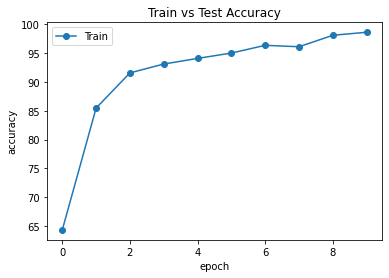

In [ ]:
plt.plot(trainAccuracy,'-o')
# plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

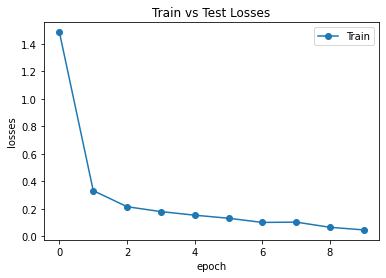

In [ ]:
plt.plot(trainLoss,'-o')
# plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [ ]:
zzz

NameError: ignored

In [ ]:
# class Net(nn.Module):
#     layers = []
#     def __init__(self, alexNet):
#         super(Net, self).__init__()
#         self.conv2d1 = Conv2d(3, 64, 11, stride=3, padding=0)
#         self.relu1 = alexNet.features[1]
#         self.pool1 = alexNet.features[2]
#         self.conv2d2 = alexNet.features[3]
#         self.relu2 = alexNet.features[4]
#         self.pool2 = alexNet.features[5]
#         self.conv2d3 = alexNet.features[6]
#         self.relu3 = alexNet.features[7]
#         self.conv2d4 = alexNet.features[8]
#         self.relu4 = alexNet.features[9]
#         self.conv2d5 = Conv2d(256, 256, 11, stride=1, padding=1)
#         self.relu5 = alexNet.features[11]
#         self.pool5 = alexNet.features[12]
#         self.fc6 = Linear(256 * 4 * 4, 4096,bias=True)
#         self.relu6 = alexNet.classifier[2]
#         self.drop6 = alexNet.classifier[0]
#         self.fc7 = Linear(4096,2048,bias=True)
#         self.relu7 = alexNet.classifier[2]
#         self.drop7 = alexNet.classifier[0]
#         self.fc8 = Linear(2048,1024,bias=True)
#         self.relu8 = alexNet.classifier[2]
#         self.drop8 = alexNet.classifier[0]
#         self.fc9 = Linear(1024,2,True)
#         # self.cl = Softmax(dim = -1) #error
#         self.layers = [self.conv2d1,self.relu1,self.pool1,
#                        self.conv2d2,self.relu2,self.pool2,
#                        self.conv2d3,self.relu3,
#                        self.conv2d4,self.relu4,
#                        self.conv2d5,self.relu5,self.pool5,
#                        self.fc6,self.relu6,self.drop6,
#                        self.fc7,self.relu7,self.drop7,
#                        self.fc8, self.relu8,self.drop8,
#                        self.fc9]

#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv2d1(x)))
#         x = self.pool2(self.relu2(self.conv2d2(x)))
#         x = self.relu3(self.conv2d3(x))
#         x = self.relu4(self.conv2d4(x))
#         x = self.pool5(self.relu5(self.conv2d5(x)))

#         x = x.view(-1,256 * 4 * 4)
#         x = self.drop6(self.relu6(self.fc6(x)))
#         x = self.drop7(self.relu7(self.fc7(x)))
#         x = self.drop8(self.relu8(self.fc8(x)))
#         x = self.fc9(x)

#         x = softmax(x, dim = 1)
#         # print(x)
#         return x

In [29]:
net1 = alexNet
net1.features[0] = Conv2d(3, 64, 11, stride=3, padding=0)
# net1.classifier[4].out_features = 2048
# net1.classifier[6].in_features = 2048
net1 = net1.to(device)

In [30]:
alexNet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

In [31]:
net1.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

In [32]:
learnRate = .001
weight_decay = .1

In [33]:
opt = SGD(net1.parameters(), lr=0.001, momentum=0.9)

opt1 = Adam([
                {'params': net1.features[0].weight, 'lr': learnRate * 2},
                {'params': net1.features[0].bias, 'lr': learnRate}]
                , weight_decay=weight_decay)
opt2 = Adam([
                {'params': net1.classifier[1].weight, 'lr': learnRate * 2},
                {'params': net1.classifier[1].bias, 'lr': learnRate * 2}]
                , weight_decay=weight_decay)
opt3 = Adam([
                {'params': net1.classifier[4].weight, 'lr': learnRate * 2},
                {'params': net1.classifier[4].bias, 'lr': learnRate * 2}]
                , weight_decay=weight_decay)
opt4 = Adam([
                {'params': net1.classifier[6].weight, 'lr': learnRate * 2},
                {'params': net1.classifier[6].bias, 'lr': learnRate * 2}]
                , weight_decay=weight_decay)


In [ ]:
torch.cuda.is_available()

True

In [34]:
def train(epoch,epochs, net1,trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt,criterion):
    running_loss = 0
    total, correct = 0, 0
    # for data in trainLoader:
    for data in tqdm(trainLoader):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # opt1.zero_grad()
      # opt2.zero_grad()
      # opt3.zero_grad()
      # opt4.zero_grad()
      opt.zero_grad()

      outputs = net1(inputs)
      loss = criterion(outputs, labels)
      loss.backward(retain_graph=True)

      # opt1.step()
      # opt2.step()
      # opt3.step()
      # opt4.step()
      opt.step()

      running_loss += loss.item() / len(trainLoader)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    # print("weight of first layer is ", net1.layers[0].weight)


    accuracy = 100 * correct / total
    trainAccuracy.append(accuracy)
    trainLoss.append(running_loss)
    print("\nTRAIN: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy, running_loss))


In [38]:
def test(epoch, epochs, net1,testLoader,testAccuracy,testLoss,criterion):    
  running_loss = 0
  total, correct = 0, 0
  with torch.no_grad():
    # for data in testLoader:
    for data in tqdm(testLoader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = net1(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() / len(testLoader)
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    testAccuracy.append(accuracy)
    testLoss.append(running_loss)

    print("\nTEST: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy, running_loss))


In [39]:
epochs = 10
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

for epoch in range(epochs):  # loop over the dataset multiple times
  train(epoch, epochs, net1, trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt,criterion)
  test(epoch, epochs, net1,testLoader,testAccuracy,testLoss,criterion)

100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 1/10, Accuracy: 92.364, Loss: 0.190


100%|██████████| 12/12 [10:22<00:00, 51.89s/it]



TEST: Epoch 1/10, Accuracy: 79.657, Loss: 0.768


100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 2/10, Accuracy: 92.983, Loss: 0.174


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]



TEST: Epoch 2/10, Accuracy: 88.143, Loss: 0.317


100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 3/10, Accuracy: 94.260, Loss: 0.150


100%|██████████| 12/12 [00:17<00:00,  1.49s/it]



TEST: Epoch 3/10, Accuracy: 85.615, Loss: 0.359


100%|██████████| 26/26 [01:02<00:00,  2.40s/it]



TRAIN: Epoch 4/10, Accuracy: 96.853, Loss: 0.100


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]



TEST: Epoch 4/10, Accuracy: 86.548, Loss: 0.387


100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 5/10, Accuracy: 96.917, Loss: 0.090


100%|██████████| 12/12 [00:17<00:00,  1.49s/it]



TEST: Epoch 5/10, Accuracy: 88.565, Loss: 0.308


100%|██████████| 26/26 [01:02<00:00,  2.40s/it]



TRAIN: Epoch 6/10, Accuracy: 96.608, Loss: 0.098


100%|██████████| 12/12 [00:17<00:00,  1.50s/it]



TEST: Epoch 6/10, Accuracy: 87.210, Loss: 0.342


100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 7/10, Accuracy: 97.498, Loss: 0.077


100%|██████████| 12/12 [00:17<00:00,  1.50s/it]



TEST: Epoch 7/10, Accuracy: 87.421, Loss: 0.381


100%|██████████| 26/26 [01:02<00:00,  2.40s/it]



TRAIN: Epoch 8/10, Accuracy: 97.407, Loss: 0.078


100%|██████████| 12/12 [00:18<00:00,  1.51s/it]



TEST: Epoch 8/10, Accuracy: 87.331, Loss: 0.371


100%|██████████| 26/26 [01:02<00:00,  2.40s/it]



TRAIN: Epoch 9/10, Accuracy: 98.233, Loss: 0.060


100%|██████████| 12/12 [00:18<00:00,  1.50s/it]



TEST: Epoch 9/10, Accuracy: 84.141, Loss: 0.633


100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 10/10, Accuracy: 97.640, Loss: 0.069


100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


TEST: Epoch 10/10, Accuracy: 86.247, Loss: 0.460


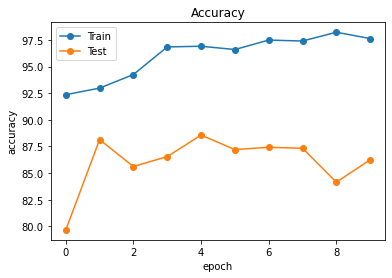

In [43]:
plt.plot(trainAccuracy,'-o')
plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Accuracy')
 
plt.show()

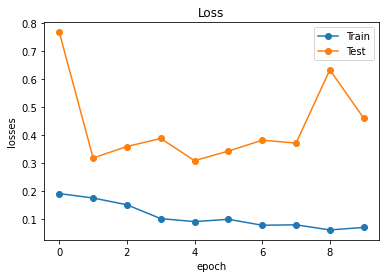

In [42]:
plt.plot(trainLoss,'-o')
plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Loss')
 
plt.show()

In [ ]:
zzz

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean), (1))])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = read_csv(csv_path)
        self.imagesFolder = images_folder
        self.transform = transform
        self.class2index = {"male":0, "female":1}

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        filename = self.df["imageName"][index]
        label = self.class2index[self.df["gender"][index]]
        image = getPartOfMat(loadmat(self.imagesFolder + "/" + filename[:-3] + "mat"), "high")
        if self.transform is not None:
          image = self.transform(image)
        return image, label
      
    def images(self):
      return glob(self.imagesFolder + "/*.mat")
        

In [ ]:
def getMean(outs):
  sum = 0
  for out in range(len(outs)):
    if out % 100 == 0: print(out)
    mat = loadmat(outs[out])
    image = mat['O'][:,:,3]
    sum += image[:,:].mean()
  mean = sum / len(outs)
  return mean
# mean = getMean(outs)


In [ ]:
dataset = CustomDataset(LABEL_PATH, OUT_PATH, transform)
img, label = dataset[100]
img.shape

In [ ]:
batch_size = 80
validation_split = 0.7
shuffle_dataset = True
dataset_size = len(dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
testLoader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
len(trainLoader)

In [ ]:
len(testLoader)

In [ ]:
class Net(nn.Module):
    def __init__(self, alexNet):
        super(Net, self).__init__()
        self.conv2d1 = Conv2d(1, 64, 11, stride=3, padding=0)
        self.relu1 = alexNet.features[1]
        self.pool1 = alexNet.features[2]
        self.conv2d2 = alexNet.features[3]
        self.relu2 = alexNet.features[4]
        self.pool2 = alexNet.features[5]
        self.conv2d3 = alexNet.features[6]
        self.relu3 = alexNet.features[7]
        self.conv2d4 = alexNet.features[8]
        self.relu4 = alexNet.features[9]
        self.conv2d5 = Conv2d(256, 256, 11, stride=1, padding=1)
        self.relu5 = alexNet.features[11]
        self.pool5 = alexNet.features[12]
        self.fc6 = Linear(256 * 4 * 4, 4096,bias=True)
        self.relu6 = alexNet.classifier[2]
        self.drop6 = alexNet.classifier[0]
        self.fc7 = Linear(4096,4096,bias=True)
        self.relu7 = alexNet.classifier[2]
        self.drop7 = alexNet.classifier[0]
        self.fc8 = Linear(4096,2048,bias=True)
        self.relu8 = alexNet.classifier[2]
        self.drop8 = alexNet.classifier[0]
        self.fc9 = Linear(2048,2048,True)
        self.relu9 = alexNet.classifier[2]
        self.drop9 = alexNet.classifier[0]
        self.fc9_ = Linear(2048, 2, True)
        
        self.layers = [self.conv2d1,self.relu1,self.pool1,
                       self.conv2d2,self.relu2,self.pool2,
                       self.conv2d3,self.relu3,
                       self.conv2d4,self.relu4,
                       self.conv2d5,self.relu5,self.pool5,
                       self.fc6,self.relu6,self.drop6,
                       self.fc7,self.relu7,self.drop7,
                       self.fc8,self.relu8,self.drop8,
                       self.fc9,self.relu9,self.drop9,self.fc9_]

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv2d1(x)))
        x = self.pool2(self.relu2(self.conv2d2(x)))
        x = self.relu3(self.conv2d3(x))
        x = self.relu4(self.conv2d4(x))
        x = self.pool5(self.relu5(self.conv2d5(x)))
        x = x.view(-1,256 * 4 * 4)
        x = self.drop6(self.relu6(self.fc6(x)))
        x = self.drop7(self.relu7(self.fc7(x)))
        x = self.drop8(self.relu8(self.fc8(x)))
        x = self.drop9(self.relu9(self.fc9(x)))
        x = self.fc9_(x)
        x = softmax(x, dim = 1)
        return x

In [ ]:
learnRate = .01

In [ ]:
net2 = Net(alexNet).to(device)
net2

In [ ]:
opt1 = Adam([
                {'params': net2.conv2d1.weight, 'lr': learnRate},
                {'params': net2.conv2d1.bias, 'lr': learnRate}]
                , weight_decay=0.8)
opt2 = Adam([
                {'params': net2.fc6.weight, 'lr': learnRate * 2},
                {'params': net2.fc6.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)
opt3 = Adam([
                {'params': net2.fc7.weight, 'lr': learnRate * 2},
                {'params': net2.fc7.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)
opt4 = Adam([
                {'params': net2.fc8.weight, 'lr': learnRate * 2},
                {'params': net2.fc8.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)
opt5 = Adam([
                {'params': net2.fc9.weight, 'lr': learnRate * 2},
                {'params': net2.fc9.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)

opt6 = Adam([
                {'params': net2.fc9_.weight, 'lr': learnRate * 2},
                {'params': net2.fc9_.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)

opt = SGD(net2.parameters(), lr=0.0001)

In [ ]:
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

In [ ]:
def train(epoch, epochs, net2, trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt5,opt6,opt,criterion)
    running_loss = 0
    total, correct = 0, 0
    for data in trainLoader:
    # for data in tqdm(trainLoader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      opt1.zero_grad()
      opt2.zero_grad()
      opt3.zero_grad()
      opt4.zero_grad()
      opt5.zero_grad()
      opt6.zero_grad()
      opt.zero_grad()

      outputs = net2(inputs)
      loss = criterion(outputs, labels)
      loss.backward()

      opt1.step()
      opt2.step()
      opt3.step()
      opt4.step()
      opt5.step()
      opt6.step()
      opt.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    loss = running_loss / len(trainLoader)
    trainAccuracy.append(accuracy)
    trainLoss.append(loss)

    print("\nTRAIN: Epoch {}/{}, Accuracy: {:.3f}".format(epoch+1,epochs, 100 * correct/total))


In [ ]:
def test(epoch, epochs, net2,testLoader,testAccuracy,testLoss,criterion):    
  running_loss = 0
  total, correct = 0, 0
  with torch.no_grad():
    for data in testLoader:
    # for data in tqdm(testLoader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = net2(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    loss = running_loss / len(testLoader)
    testAccuracy.append(accuracy)
    testLoss.append(loss)

    print("\nTEST: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy,loss))


In [ ]:
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
  train(epoch, epochs, net2, trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt5,opt6,opt,criterion)
  test(epoch, epochs, net2,testLoader,testAccuracy,testLoss,criterion)  

In [ ]:
plt.plot(trainAccuracy,'-o')
plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
plt.plot(trainLoss,'-o')
plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [ ]:
zzz

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean1, mean2, mean3, mean), (1, 1, 1, 1))])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = read_csv(csv_path)
        self.imagesFolder = images_folder
        self.transform = transform
        self.class2index = {"male":0, "female":1}

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        filename = self.df["imageName"][index]
        label = self.class2index[self.df["gender"][index]]
        image = getPartOfMat(loadmat(self.imagesFolder + "/" + filename[:-3] + "mat"), "normal")
        if self.transform is not None:
          image = self.transform(image)
        return image, label
      
    def images(self):
      return glob(self.imagesFolder + "/*.mat")
        

In [ ]:
dataset = CustomDataset(LABEL_PATH, OUT_PATH, transform)
img, label = dataset[100]
img.shape

In [ ]:
epochs = 20
batch_size = 80
validation_split = 0.7
shuffle_dataset = True
dataset_size = len(dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
testLoader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
len(trainLoader)

In [ ]:
len(testLoader)

In [ ]:
class Net(nn.Module):
    def __init__(self,alexNet, net1, net2):
        super(Net, self).__init__()
        self.skipConv1 = Conv2d(4, 64, 11, stride=3, padding=2)
        self.skipConv2 = Conv2d(4, 64, 11, stride=3, padding=2)
        self.relu1 = net1.layers[1]
        self.pool1 = net1.layers[2]
        self.conv2d2 = net1.layers[3]
        self.relu2 = net1.layers[4]
        self.pool2 = net1.layers[5]
        self.conv2d3 = net1.layers[6]
        self.relu3 = net1.layers[7]
        self.conv2d4 = net1.layers[8]
        self.relu4 = net1.layers[9]
        self.conv2d5 = net1.layers[10]
        self.relu5 = net1.layers[11]
        self.pool5 = net1.layers[12]
        self.fc6 = net1.layers[13]
        self.relu6 = alexNet.classifier[2]
        self.drop6 = alexNet.classifier[0]
        self.fc7 = Linear(4096,4096,bias=True)
        self.relu7 = alexNet.classifier[2]
        self.drop7 = alexNet.classifier[0]
        self.fc8 = Linear(4096,2048,bias=True)
        self.relu8 = alexNet.classifier[2]
        self.drop8 = alexNet.classifier[0]
        self.fc9 = Linear(2048,2,True)
        #
        
        self.relu9 = alexNet.classifier[2]
        self.drop9 = alexNet.classifier[0]
        # self.cl = Softmax(dim = -1) #error

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv2d1(x)))
        x = self.pool2(self.relu2(self.conv2d2(x)))
        x = self.relu3(self.conv2d3(x))
        x = self.relu4(self.conv2d4(x))
        x = self.pool5(self.relu5(self.conv2d5(x)))

        x = x.view(-1,256 * 4 * 4)
        x = self.drop6(self.relu6(self.fc6(x)))
        x = self.drop7(self.relu7(self.fc7(x)))
        x = self.drop8(self.relu8(self.fc8(x)))
        x = self.drop9(self.relu9(self.fc9(x)))

        x = softmax(x, dim = 1)
        # print(x)
        return x

In [ ]:
twoStream = Net(alexNet).to(device)
opt1 = Adam([
                {'params': net1.skipConv1.weight, 'lr': 0},
                {'params': net1.skipConv1.bias, 'lr': 0}]
                , weight_decay=1)
opt2 = Adam([
                {'params': net1.skipConv2.weight, 'lr': 0},
                {'params': net1.skipConv2.bias, 'lr': 0}]
                , weight_decay=1)
# opt2 = Adam([
#                 {'params': net1.fc6.weight, 'lr': 20 * 2},
#                 {'params': net1.fc6.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)
# opt3 = Adam([
#                 {'params': net1.fc7.weight, 'lr': 20 * 2},
#                 {'params': net1.fc7.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)
# opt4 = Adam([
#                 {'params': net1.fc8.weight, 'lr': 20 * 2},
#                 {'params': net1.fc8.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)
# opt5 = Adam([
#                 {'params': net1.fc9.weight, 'lr': 20 * 2},
#                 {'params': net1.fc9.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)

# opt = SGD(net1.parameters(), lr=0.0001)


In [ ]:
twoStream

In [ ]:
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

In [ ]:
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0
    total, correct = 0, 0
    for data in trainLoader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      opt1.zero_grad()
      opt2.zero_grad()
      opt3.zero_grad()
      opt4.zero_grad()
      opt5.zero_grad()
      opt.zero_grad()

      outputs = net1(inputs)
      loss = criterion(outputs, labels)
      loss.backward()

      opt1.step()
      opt2.step()
      opt3.step()
      opt4.step()
      opt5.step()
      opt.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    loss = running_loss / len(trainLoader)
    trainAccuracy.append(accuracy)
    trainLoss.append(loss)
    print("\nEpoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy,loss))

print('Finished Training')

In [ ]:
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0
    total, correct = 0, 0
    with torch.no_grad():
      for data in testLoader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        running_loss+=loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

      accuracy = 100 * correct / total
      loss = running_loss / len(testLoader)
      testAccuracy.append(accuracy)
      testLoss.append(loss)

      print("\nEpoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,num_epochs, accuracy,loss))

print('Finished Testing')

In [ ]:
plt.plot(trainAccuracy,'-o')
plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
plt.plot(trainLoss,'-o')
plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Valid Losses')
 
plt.show()